# Template for coursework - Part 2: Clustering

In [69]:
# import of libraries
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from scipy import stats
import numpy as np



## Team identification

* seminar day and time
ST 9:15
* team number
Team D
* names of team members
Michal Červinka, Filip Dvořák, Tomáš Jareš, Dominik Šimon

# Introduction

1.	Describe the business value of addressing this problem with machine learning.

    Použití strojového učení na dataset diabetu může výrazně přispět k zlepšení zdravotní péče. Umožňuje časnou detekci a diagnostiku diabetu, vytváření personalizovaných léčebných plánů, předpovídání pravděpodobnosti komplikací, stratifikaci pacientů na základě rizika a efektivní řízení a sledování nemoci. Tímto způsobem může strojové učení zlepšit klinické 
    rozhodování, výsledky pacientů a přispět k efektivnějšímu poskytování zdravotní péče.

2.	Provide the link to the source of the data.
    https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

## Customization

//TODO

1.	What is the *target attribute*
2.	What is the *instance of interest*   The instance can be identified, for example, by an id.
3.	Choose an *attribute of interest* 
5.	Show *Cost matrix* consisting of a cost of a false positive, false negative, true positive and true negative. Note that cost of true positive and true negative is recommended to be zero.

# Data preprocessing

## Preprocessing for unsupervised machine learning 

* As clustering is  performed only on the chosen subset of data, remove data not in the subgroup
* Perform min-max feature rescaling
* remove target attribute from clustering
* do *not* create train-test splits

In [70]:

data = pd.read_csv("diabetes_prediction_dataset.csv")
data

#Vybrání dat bez cílové proměnné
X = data.drop('diabetes', axis=1)

#Vytvoření subsetu
X=X.drop('gender', axis=1)
X=X.drop('smoking_history',axis=1)
print(X.head())

np.random.seed(10)
X = X.sample(frac=0.01, random_state=11)


# Calculate z-scores for each column in X
z_scores = stats.zscore(X)

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 3

# Remove rows with z-scores greater than the threshold
X = X[(np.abs(z_scores) < threshold).all(axis=1)]

#Doplnění chbějících pozorování pro smoking history
#value_counts = X[X['smoking_history'] != 'No Info']['smoking_history'].value_counts()
#total_count = value_counts.sum()
#distribution = (X['smoking_history'].value_counts() / total_count).drop('No Info')
#random= np.random.choice(distribution.index,X[X['smoking_history'] == 'No Info'].shape[0] ,p=distribution.values)

#X['smoking_history'].loc[X['smoking_history'] == 'No Info'] = random


#Odebrání řádků, kde je atribut gender "Other"
#X = X.drop(X[X['gender'] == 'Other'].index)

#Převedení kategoriálních atributů na binární
#X = pd.get_dummies(X, columns=['gender'])
#print(X['smoking_history'].value_counts())
#X = pd.get_dummies(X, columns=['smoking_history'])



#MinMax scaling
scaler = StandardScaler()
X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(X[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']])
print(X.describe()) #tabulka pro kontrolu min a max value 

print("Number of rows in X:", X.shape[0])



    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level
0  80.0             0              1  25.19          6.6                  140
1  54.0             0              0  27.32          6.6                   80
2  28.0             0              0  27.32          5.7                  158
3  36.0             0              0  23.45          5.0                  155
4  76.0             1              1  20.14          4.8                  155
                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  8.660000e+02         866.0          866.0  8.660000e+02  8.660000e+02   
mean   3.261440e-16           0.0            0.0  1.948659e-16  6.892100e-16   
std    1.000578e+00           0.0            0.0  1.000578e+00  1.000578e+00   
min   -1.786615e+00           0.0            0.0 -2.232469e+00 -1.928265e+00   
25%   -8.492887e-01           0.0            0.0 -6.537951e-01 -6.301482e-01   
50%   -2.442267e-02           0.0            0.0  1.

## Modeling and visualization

* do not include target attribute among variables for clustering

### Clustering 1 (k-means)

* Use the elbow curve graph to find the best value of inertia (wcss)
* It is recommended to use two measures (such as the Silhouette score and the Inertia) and compare the resulting number of clusters based on their best values.
* Create a scatter plot for each cluster and use color

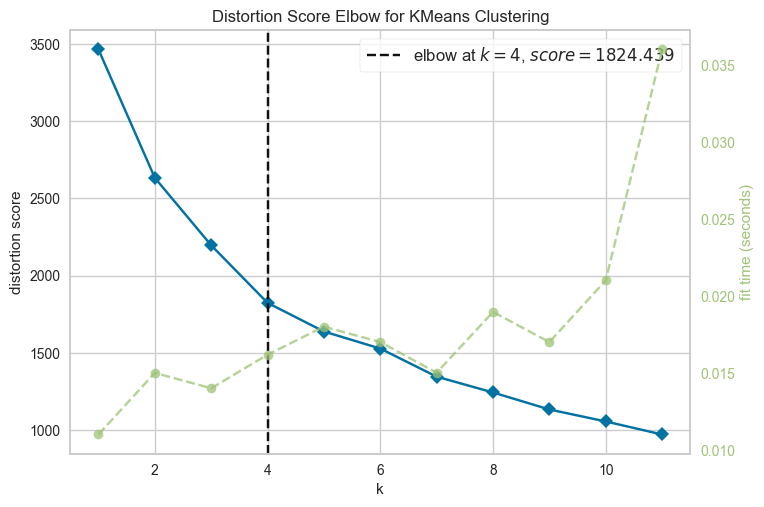

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
#KElbow visualization
kmeans_tune = KMeans(random_state=42,n_init = 2,max_iter=10)
visualizer = KElbowVisualizer(kmeans_tune, k=(1,12))
visualizer.fit(X)
visualizer.show()

In [72]:
kmeansElbow = KMeans(n_clusters=5, random_state=42)
kmeansElbow.fit(X)
# spočítání Silhouette Score:
silhouette_avg = silhouette_score(X, kmeansElbow.labels_)
print("silhouette_score pro k=5:", silhouette_avg)

#výpis inertii
print("inertia pro k=5: ", kmeansElbow.inertia_)

kmeansTwo = KMeans(n_clusters=2, random_state=42)
kmeansTwo.fit(X)
# spočítání Silhouette Score:
silhouette_avg = silhouette_score(X, kmeansTwo.labels_)
print("silhouette_score pro k=2:", silhouette_avg)
#výpis inertii
print("inertia pro k=2: ", kmeansTwo.inertia_)


silhouette_score pro k=5: 0.21799459321356035
inertia pro k=5:  1667.2147880936704
silhouette_score pro k=2: 0.2202006337086197
inertia pro k=2:  2633.459405930618


C:\Users\cervi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


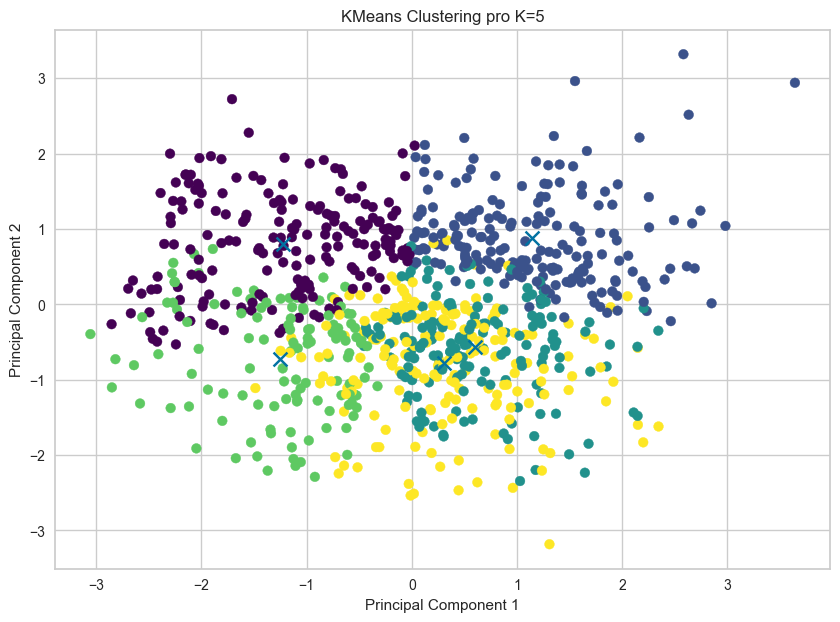

C:\Users\cervi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


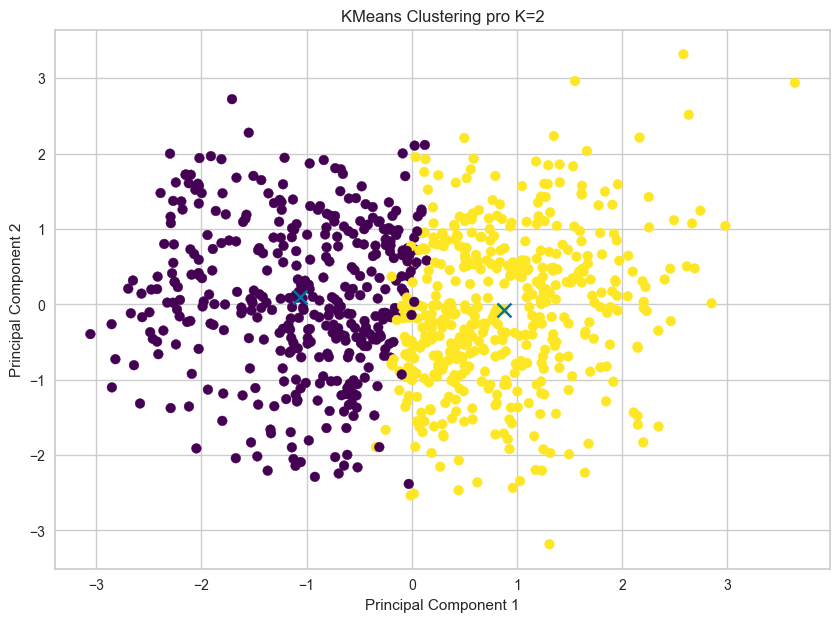

In [73]:
# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

# Transform the centroids
centroids = pca.transform(kmeansElbow.cluster_centers_)

# Create a DataFrame with the two principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Add the cluster labels to this DataFrame
principalDf['Cluster'] = kmeansElbow.labels_

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering pro K=5')
plt.show()

centroids = pca.transform(kmeansTwo.cluster_centers_)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['Cluster'] = kmeansTwo.labels_
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering pro K=2')
plt.show()

### Clustering  2 (hierarchical)

* Try to use the dendrogram to identify outliers. If an instance joins a cluster higher on the dendrogram, it generally means it is less similar to the other instances. 

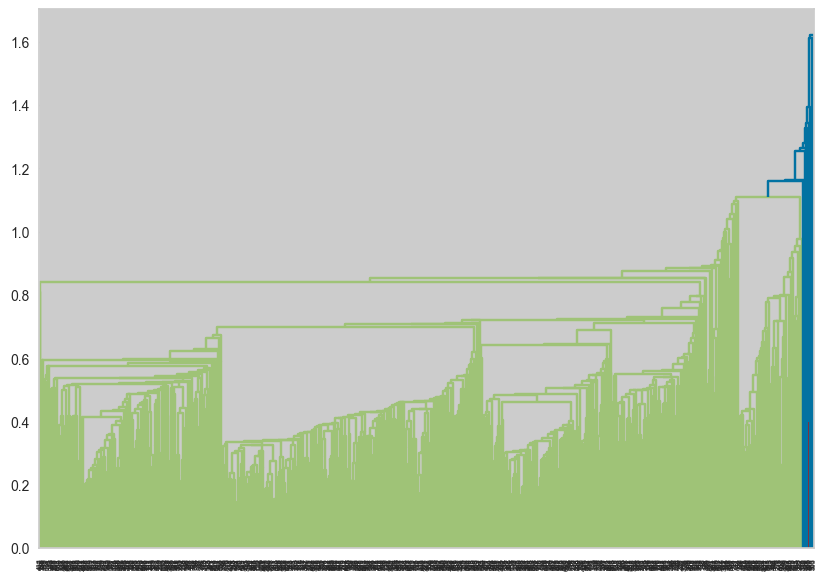

In [74]:
# Perform hierarchical clustering
linked = linkage(X, 'single')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# Evaluation

## Global

### Clustering 1 (k-means)

* Compute the rand index using the value of the target attribute

In [75]:
# Assuming 'data' is your original DataFrame and 'X' is your preprocessed data
y = data.loc[X.index, 'diabetes']

# Compute Adjusted Rand Index
ari = adjusted_rand_score(y, kmeansElbow.labels_)
ariTwo = adjusted_rand_score(y,kmeansTwo.labels_)

print("ARI pro k=5: ", ari)
print("ARI pro k=2: ", ariTwo)


ARI pro k=5:  -0.0002340720821516797
ARI pro k=2:  -0.006539700904146268


### Clustering 2 (hierarchical)


* Compute the rand index using the value of the target attribute

In [76]:
# Assuming 'Z' is the linkage matrix obtained from hierarchical clustering
# and 'k' is the number of clusters you decided based on the dendrogram
clusters = fcluster(linked, 7, criterion='maxclust')

# Assuming 'data' is your original DataFrame and 'X' is your preprocessed data
y = data.loc[X.index, 'diabetes']

# Compute Adjusted Rand Index
ari = adjusted_rand_score(y, clusters)

print("ARI: ", ari)

ARI:  0.2678050370440913


## Local

*	Use the model to classify the chosen instance into a cluster

Cluster label:  [2]


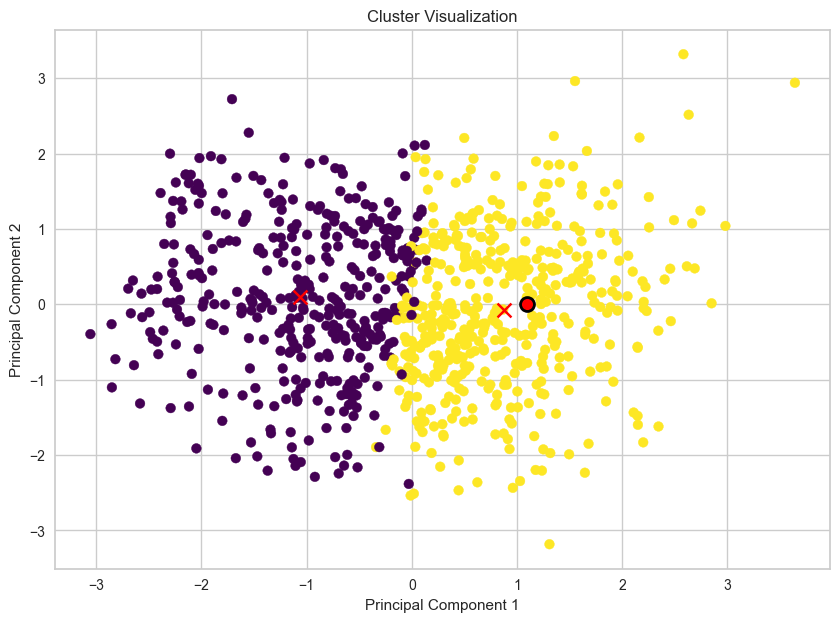

In [77]:
# Klasifikace instance do shluku pomocí K-means
#set variable instance_of_interest to the first row of the test set
instance_of_interest = X.iloc[0]

#reshape the instance_of_interest to match the input of the model
instance_of_interest = instance_of_interest.values.reshape(1, -1)
instance_of_interest = pd.DataFrame(instance_of_interest, columns=X.columns)

cluster_label = kmeansElbow.predict(instance_of_interest)
print("Cluster label: ", cluster_label)

# Předpokládáme, že 'X' je váš dataset a 'kmeans' je váš natrénovaný model
labels = kmeansElbow.labels_


# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], c=principalDf['Cluster'], cmap='viridis')

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c="red",s=100)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.scatter(instance_of_interest.iloc[0, 0], instance_of_interest.iloc[0, 1], c='red', edgecolor='black', linewidth=2, s=100)
plt.show()


# Explanation

## Global explanation

### Clustering 1 - k-means

*	Interpret the final clusters based on their centroids and the number of instances in each cluster.

In [78]:
# New code for interpreting the clusters
# Get the cluster centroids
centroids = kmeansElbow.cluster_centers_

# Get the count of instances in each cluster
unique, counts = np.unique(kmeansElbow.labels_, return_counts=True)
cluster_counts = dict(zip(unique, counts))

# Print the centroids
print("Cluster Centroids:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}:")
    for j, column in enumerate(X.columns):
        print(f"{column}: {centroid[j]}")

# Print the number of instances in each cluster
print("\nNumber of Instances in Each Cluster:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} instances")

Cluster Centroids:
Cluster 0:
age: -1.0468599877019422
hypertension: 0.0
heart_disease: 0.0
bmi: -0.9276979460221928
HbA1c_level: 0.11745834782535151
blood_glucose_level: 0.5024515412462228
Cluster 1:
age: 0.7409460058921994
hypertension: 0.0
heart_disease: 0.0
bmi: 0.4699775049485601
HbA1c_level: 0.774884232347407
blood_glucose_level: 0.8486536497636579
Cluster 2:
age: 0.5667036764038503
hypertension: 0.0
heart_disease: 0.0
bmi: 0.4614763134157013
HbA1c_level: 0.4635033385709778
blood_glucose_level: -0.9857385818365394
Cluster 3:
age: -0.8245675000555058
hypertension: 0.0
heart_disease: 0.0
bmi: -0.6035895121405558
HbA1c_level: -0.20453612834940585
blood_glucose_level: -1.244005443142818
Cluster 4:
age: 0.31355061954727564
hypertension: 0.0
heart_disease: 0.0
bmi: 0.4291158371001825
HbA1c_level: -1.223405217437032
blood_glucose_level: 0.28540683839962616

Number of Instances in Each Cluster:
Cluster 0: 191 instances
Cluster 1: 198 instances
Cluster 2: 168 instances
Cluster 3: 122 inst

### Clustering 2 - hierarchical

* Plot the dendrogram for clustering

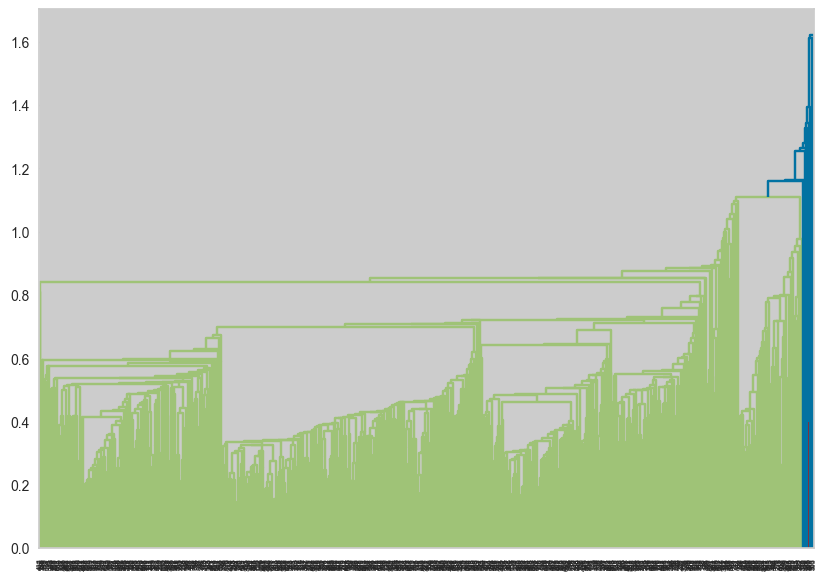

In [79]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

## Local explanation

* Use both models to show what cluster is assigned to the *instance of interest*
* Comment on the assigned cluster.

In [80]:
# K-means model
kmeans_cluster = kmeansElbow.predict(instance_of_interest)
print("K-means Cluster: ", kmeans_cluster)

# Hierarchical model
hierarchical_cluster = fcluster(linked, 5, criterion='maxclust')
hierarchical_cluster = hierarchical_cluster[0]  # Assuming instance_of_interest is the first row
print("Hierarchical Cluster: ", hierarchical_cluster)




K-means Cluster:  [2]
Hierarchical Cluster:  3


# Conclusion
Summarize the results, answering questions such as:

1.	Which clustering provided the most useful result? 
    Kmeans (lepší ari )
2.	What setting provided the best result?
    K= 5 - zjištěno z elbow grafu

# Optional parts

## Local explanation

*	Does the value of the target class in the data match with the mode (average) of the assigned cluster? As the target attribute was not included in the clustering, to compute this, you need to  match the instance of interest as well as the instances in the assigned cluster with the original input data and use this to obtain the target value (and compute the mean/mode for the assigned cluster)